# Word Embeddings

## Notebook for Assignment 2 of the "Text as Data" Course

**Assignment: Word Embeddings and Vector Space Arithmetic**

### Purpose
The purpose of this assignment is to familiarize you with word embeddings and demonstrate how they can represent words in a vector space. You will gain experience performing arithmetic operations on word vectors and explore how these operations capture semantic relationships between words.

Word embeddings are powerful tools in Natural Language Processing (NLP) that map words to high-dimensional vectors based on their contexts within a corpus. These vectors encapsulate semantic meanings and relationships, allowing for mathematical operations that reflect linguistic analogies and similarities.

In this assignment, you will:

1. **Understanding Word Embeddings**  
   - Learn how word embeddings represent semantic meaning.

2. **Vector Arithmetic with Word Embeddings**  
   - Use vector operations to explore word relationships (e.g., _king_ - _man_ + _woman_ ≈ _queen_).

3. **Identifying Latent Topics in Text**  
   - Apply word embeddings to uncover underlying topics in a corpus.

4. **Reflections on Word Embeddings in Campaign Language**  
   - Analyze how word embeddings can enhance a presidential campaign’s language strategy.

**Note:** The code in this notebook is not designed to automatically complete all the assignments. You may need to rearrange and supplement the code to arrive at solutions. Additionally, keep in mind that you are not obligated to use the provided code. You are welcome to write your own code or approach the exercises in a more reflective and analytical manner.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Natural Language Processing libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Other basic libraries
import string
import os
from scipy import spatial

# For stemming or lemmatization (optional)
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Import necessary libraries
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

# Import ml libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Download NLTK data files (only need to run once)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [2]:
# Load the dataset (adjust the file path as needed)

# Define the path to your speech files
speech_directory = 'data/sotu/'  # Replace with your actual path

# Get a list of all .txt files in the directory
speech_files = [f for f in os.listdir(speech_directory) if f.endswith('.txt')]

# Initialize lists to store data
presidents = []
years = []
texts = []

# Loop through each file and extract data
for filename in speech_files:
    # Extract president and year from the filename
    name_year = filename.replace('.txt', '')
    try:
        president, year = name_year.rsplit('_', 1)
    except ValueError:
        # Handle files that do not follow the expected naming convention
        print(f"Filename '{filename}' does not match the expected format.")
        continue
    
    # Read the text content of the file
    with open(os.path.join(speech_directory, filename), 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Append the data to the lists
    presidents.append(president)
    years.append(int(year))
    texts.append(text)

# Create a DataFrame from the lists
data = pd.DataFrame({
    'president': presidents,
    'year': years,
    'text': texts
})

# Preview the DataFrame
print(data.head())


  president  year                                               text
0     Adams  1797  Gentlemen of the Senate and Gentlemen of the H...
1     Adams  1798  Gentlemen of the Senate and Gentlemen of the H...
2     Adams  1799  Gentlemen of the Senate and Gentlemen of the H...
3     Adams  1800  Gentlemen of the Senate and Gentlemen of the H...
4     Adams  1825  Fellow Citizens of the Senate and of the House...


In [3]:
# Data Preprocessing
# Initialize stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

# Initialize stemmer or lemmatizer (choose one)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a preprocessing function
def preprocess_text(text, use_stemming=False, use_lemmatization=False):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Remove punctuation from each token and remove tokens that are punctuation
    tokens = [word for word in tokens if word not in punctuations]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Optionally perform stemming or lemmatization
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    elif use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply the preprocessing function to the 'text' column
data['tokens'] = data['text'].apply(lambda x: preprocess_text(x, use_stemming=False, use_lemmatization=True))
# No stemming or lemmatization
#data['text'].apply(lambda x: x.split(' '))

# Display the first few rows with the new 'tokens' column
data[['text', 'tokens']].head()

,text,tokens
0,Gentlemen of the Senate and Gentlemen of the H...,"[gentleman, senate, gentleman, house, represen..."
1,Gentlemen of the Senate and Gentlemen of the H...,"[gentleman, senate, gentleman, house, represen..."
2,Gentlemen of the Senate and Gentlemen of the H...,"[gentleman, senate, gentleman, house, represen..."
3,Gentlemen of the Senate and Gentlemen of the H...,"[gentleman, senate, gentleman, house, represen..."
4,Fellow Citizens of the Senate and of the House...,"[fellow, citizen, senate, house, representativ..."


In [4]:
# Example: View the tokens for the first speech
print("Original Text:\n")
print(data['text'].iloc[0][:500])  # Show first 500 characters
print("\nPreprocessed Tokens:\n")
print(data['tokens'].iloc[0][:50])  # Show first 50 tokens

Original Text:

Gentlemen of the Senate and Gentlemen of the House of Representatives:

I was for some time apprehensive that it would be necessary, on account of
the contagious sickness which afflicted the city of Philadelphia, to
convene the National Legislature at some other place. This measure it was
desirable to avoid, because it would occasion much public inconvenience and
a considerable public expense and add to the calamities of the inhabitants
of this city, whose sufferings must have excited the sympat

Preprocessed Tokens:

['gentleman', 'senate', 'gentleman', 'house', 'representative', 'time', 'apprehensive', 'would', 'necessary', 'account', 'contagious', 'sickness', 'afflicted', 'city', 'philadelphia', 'convene', 'national', 'legislature', 'place', 'measure', 'desirable', 'avoid', 'would', 'occasion', 'much', 'public', 'inconvenience', 'considerable', 'public', 'expense', 'add', 'calamity', 'inhabitant', 'city', 'whose', 'suffering', 'must', 'excited', 'sympathy', 'fellow',

In [5]:
def compute_svd_embeddings(pmi_matrix, embedding_dim=50):
    svd = TruncatedSVD(n_components=embedding_dim)
    embeddings = svd.fit_transform(pmi_matrix)
    return embeddings

### **Part 1: Training Word Embeddings**

**A. Training Your Own Word Embeddings:**
- Use a library like **gensim** to train your own Word2Vec model on the prepared corpus.
- **Set training parameters:**
  - **Vector Size:** Choose the dimensionality of the word vectors (e.g., 100, 200).
  - **Window Size:** Set the context window size (e.g., 5 words before and after).
  - **Minimum Word Frequency:** Ignore words that appear less than a certain number of times.
- Discuss why you chose these parameters.

**B. The Effect of Pre-processing:**
- Re-do the analysis from section A, but now apply the model to the original corpus.
- Select five words that are present in both datasets (original and preprocessed). Compute the cosine similarity between these words for each of the two model estimates. This will give a five-by-five table with cosine similarities for each model. How similar or different are these tables across the two model estimates? Reflect upon your findings.

**C. Using Pre-trained Word Embeddings:**
- If training your own embeddings is computationally intensive, you may use pre-trained embeddings like **GloVe** or **Word2Vec Google News vectors**.
- **Loading Pre-trained Embeddings:**
  - Download the pre-trained model.
  - Use gensim or another library to load the embeddings into your workspace.
- Re-do the comparison from section B using the pre-trained embeddings. How similar or different are these tables across the two model estimates? Reflect upon your findings.

**D. Word Embeddings from PMI Matrix:**
- Use either the pre-processed or original corpus and construct the PMI matrix. Based on this matrix, perform a Singular Value Decomposition to obtain the word embeddings.
- Re-do the comparison from section B using the embeddings obtained from the PMI matrix. How similar or different are these tables across the model estimates? Reflect upon your findings.

In [6]:
# A. Training Your Own Word Embeddings

# Set training parameters
vector_size = 100  # Dimensionality of the word vectors
window_size = 5    # Context window size
min_word_count = 2  # Minimum word frequency to include
workers = 4        # Number of worker threads to train the model

print(f"Training parameters:\nVector Size: {vector_size}\nWindow Size: {window_size}\nMinimum Word Count: {min_word_count}")


Training parameters:
Vector Size: 100
Window Size: 5
Minimum Word Count: 2


In [7]:
# Train the Word2Vec Model

# Build the Word2Vec model
w2v_model = Word2Vec(
    sentences=data['tokens'],
    vector_size=vector_size,
    window=window_size,
    min_count=min_word_count,
    workers=workers,
    sg=1,  # Use skip-gram; set to 0 for CBOW
    epochs=5  # Number of iterations (epochs) over the corpus
)

# Build vocabulary and train the model
w2v_model.build_vocab(data['tokens'], progress_per=1000)
w2v_model.train(data['tokens'], total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(4063486, 4387290)

In [8]:
# Save the model for future use
w2v_model.save('word2vec_state_of_union.model')

# To load the model later:
# w2v_model = Word2Vec.load('word2vec_state_of_union.model')

In [9]:
# Find top 10 words most similar to 'economy'
similar_words = w2v_model.wv.most_similar('economy', topn=10)
print("Top 10 words similar to 'economy':")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

Top 10 words similar to 'economy':
healthy: 0.6744
productivity: 0.6658
competitive: 0.6635
dynamic: 0.6587
agenda: 0.6521
peacetime: 0.6515
sector: 0.6505
faster: 0.6464
stagnation: 0.6432
reconversion: 0.6396


In [10]:
# C. Using Pre-trained Word Embeddings
#  Load GloVe Embeddings into gensim

# Alternatively, use gensim's downloader to get pre-trained embeddings
# For example, to load the 'glove-wiki-gigaword-100' embeddings:
w2v_glove = api.load('glove-wiki-gigaword-100')

# Check if a word is in the vocabulary
word = 'economy'
if word in w2v_glove.key_to_index:
    print(f"'{word}' is in the pre-trained GloVe model.")
else:
    print(f"'{word}' is not in the pre-trained GloVe model.")

[==================================================] 100.0% 128.1/128.1MB downloaded
'economy' is in the pre-trained GloVe model.


In [11]:
# Find words similar to 'economy' using pre-trained GloVe embeddings
similar_words_glove = w2v_glove.most_similar('economy', topn=10)
print("Top 10 words similar to 'economy' in GloVe embeddings:")
for word, score in similar_words_glove:
    print(f"{word}: {score:.4f}")

Top 10 words similar to 'economy' in GloVe embeddings:
economic: 0.8279
growth: 0.7947
recession: 0.7692
economies: 0.7545
recovery: 0.7491
downturn: 0.7462
slowdown: 0.7368
slowing: 0.7281
sector: 0.7247
crisis: 0.7136


### **Part 2: Exploring Vector Space Arithmetic**

**E. Word Analogy Tasks:**

Use the pre-trained model and:

- **Perform arithmetic operations** on word vectors to explore semantic relationships.
  - Example: `vector('king') - vector('man') + vector('woman') ≈ vector('queen')`
- Choose at least **three** word analogies relevant to your corpus or of personal interest.
- **Document your findings:**
  - Show the computed vectors.
  - Use similarity measures (e.g., cosine similarity) to find the closest word vectors.
  - Discuss whether the expected relationships hold.

**F. Nearest Neighbors:**

- For a set of chosen words, find their **most similar words** based on cosine similarity.
- **Analyze the results:**
  - Do the similar words make sense semantically?
  - Are there any unexpected words? Why might they have appeared?

In [12]:
# Our Word2Vec Model
#w2v_model = Word2Vec.load('word2vec_state_of_union.model')

# Load the GloVe model with 100-dimensional vectors
w2v_model = api.load('glove-wiki-gigaword-100')

# Alternatively, load Word2Vec Google News model (if available)
# w2v_model = api.load('word2vec-google-news-300')

In [13]:
# Helper functions 

def cosine_similarity(vec1, vec2):
    """Compute the cosine similarity between two vectors."""
    return 1 - spatial.distance.cosine(vec1, vec2)

def analogy(word_a, word_b, word_c, model):
    """
    Compute the word analogy: word_a - word_b + word_c = ?
    Returns the top 5 most similar words.
    """
    try:
        result = model.most_similar(positive=[word_c, word_a], negative=[word_b], topn=5)
        return result
    except KeyError as e:
        print(f"One of the words is not in the vocabulary: {e}")
        return None


In [14]:
# Simmilarity between two words

cosine_similarity(w2v_model.get_vector('economy'), w2v_model.get_vector('water'))

0.36601673171351756

In [15]:
# Word Analogy: 'king' - 'man' + 'woman' = ?
result = w2v_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
#print(result)
print(f"Result of 'king' - 'man' + 'woman' = '{result[0][0]}' with similarity {result[0][1]:.4f}")

Result of 'king' - 'man' + 'woman' = 'queen' with similarity 0.7699


In [16]:
# Analogy 1
word_a = 'america'
word_b = 'american'
word_c = 'china'

result1 = analogy(word_a, word_b, word_c, w2v_model)

print(f"Analogy: '{word_a}' is to '{word_b}' as '{word_c}' is to '?'")
if result1:
    for word, score in result1:
        print(f"{word}: {score:.4f}")

Analogy: 'america' is to 'american' as 'china' is to '?'
asia: 0.7189
indonesia: 0.6663
japan: 0.6540
korea: 0.6335
thailand: 0.6313


In [17]:
# Analogy 2
word_a = 'president'
word_b = 'leader'
word_c = 'congress'

result2 = analogy(word_a, word_b, word_c, w2v_model)

print(f"\nAnalogy: '{word_a}' is to '{word_b}' as '{word_c}' is to '?'")
if result2:
    for word, score in result2:
        print(f"{word}: {score:.4f}")



Analogy: 'president' is to 'leader' as 'congress' is to '?'
administration: 0.6796
congressional: 0.6711
federal: 0.6552
legislature: 0.6305
senate: 0.6185


In [18]:
# Analogy 3
word_a = 'war'
word_b = 'enemy'
word_c = 'economy'

result3 = analogy(word_a, word_b, word_c, w2v_model)

print(f"\nAnalogy: '{word_a}' is to '{word_b}' as '{word_c}' is to '?'")
if result3:
    for word, score in result3:
        print(f"{word}: {score:.4f}")


Analogy: 'war' is to 'enemy' as 'economy' is to '?'
crisis: 0.7362
economic: 0.7279
recession: 0.6998
turmoil: 0.6676
decade: 0.6600


In [19]:
# Function to find and print most similar words
def print_similar_words(word, model, topn=10):
    try:
        similar_words = model.most_similar(word, topn=topn)
        print(f"\nTop {topn} words similar to '{word}':")
        for w, score in similar_words:
            print(f"{w}: {score:.4f}")
    except KeyError:
        print(f"'{word}' is not in the vocabulary.")

# Word 1: 'economy'
print_similar_words('economy', w2v_model)

# Word 2: 'security'
print_similar_words('security', w2v_model)

# Word 3: 'freedom'
print_similar_words('freedom', w2v_model)



Top 10 words similar to 'economy':
economic: 0.8279
growth: 0.7947
recession: 0.7692
economies: 0.7545
recovery: 0.7491
downturn: 0.7462
slowdown: 0.7368
slowing: 0.7281
sector: 0.7247
crisis: 0.7136

Top 10 words similar to 'security':
military: 0.7393
officials: 0.7230
government: 0.7116
enforcement: 0.7075
police: 0.7055
personnel: 0.7048
intelligence: 0.6963
administration: 0.6912
forces: 0.6908
civilian: 0.6907

Top 10 words similar to 'freedom':
freedoms: 0.7784
rights: 0.7624
democracy: 0.7387
liberty: 0.7168
independence: 0.7037
equality: 0.7003
dignity: 0.6816
liberties: 0.6801
respect: 0.6754
free: 0.6615


### **Part 3: Visualizing Word Embeddings**

**G. Dimensionality Reduction:**

- Use **Principal Component Analysis (PCA)** or **t-Distributed Stochastic Neighbor Embedding (t-SNE)** to reduce the dimensionality of your word vectors to 2D or 3D.
- **Select a subset** of words for visualization (e.g., frequent words, words related to a specific topic).

**H. Plotting Word Embeddings:**

- Create scatter plots of the reduced word vectors.
- **Annotate the plots** with the corresponding words.
- **Identify clusters** or groupings of semantically similar words.
- Discuss any observable patterns or anomalies in the visualization.

In [20]:
# Load pre-trained GloVe embeddings (vector size 100)
w2v_model = api.load('glove-wiki-gigaword-100')

# Check the vector size
vector_size = w2v_model.vector_size
print(f"Vector Size: {vector_size}")

Vector Size: 100


In [21]:
# Flatten the list of tokens from all speeches to get all words
all_tokens = [token for tokens in data['tokens'] for token in tokens]

# Count word frequencies
from collections import Counter
word_counts = Counter(all_tokens)

# Get the most common words
most_common_words = [word for word, count in word_counts.most_common(200)]  # Adjust the number as needed

# Filter words that are in the pre-trained model's vocabulary
words = [word for word in most_common_words if word in w2v_model.key_to_index]

print(f"Number of words selected for visualization: {len(words)}")


Number of words selected for visualization: 200


In [22]:
# Get the vectors for the selected words
word_vectors = [w2v_model[word] for word in words]

# Convert to NumPy array
word_vectors = np.array(word_vectors)


In [23]:
# Initialize PCA
pca = PCA(n_components=2)

# Fit and transform the word vectors
word_vectors_pca = pca.fit_transform(word_vectors)

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.08278227 0.07003149]


In [25]:
# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42, max_iter=1000)

# Fit and transform the word vectors
word_vectors_tsne = tsne.fit_transform(word_vectors)


c:\Users\A1010297\AppData\Local\anaconda3\envs\nlp\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


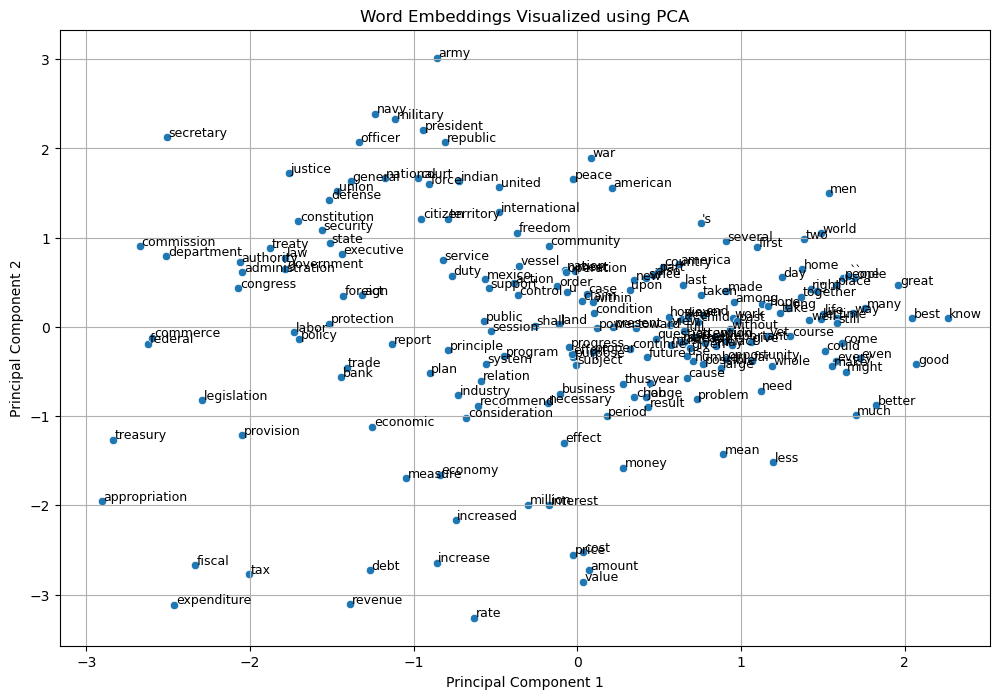

In [26]:
# Plotting the PCA-Reduced Vectors

# Create a DataFrame for plotting
df_pca = pd.DataFrame({
    'word': words,
    'x': word_vectors_pca[:, 0],
    'y': word_vectors_pca[:, 1]
})

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='x', y='y')

# Annotate the points with words
for i in range(len(df_pca)):
    plt.text(df_pca['x'][i]+0.01, df_pca['y'][i]+0.01, df_pca['word'][i], fontsize=9)

plt.title('Word Embeddings Visualized using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


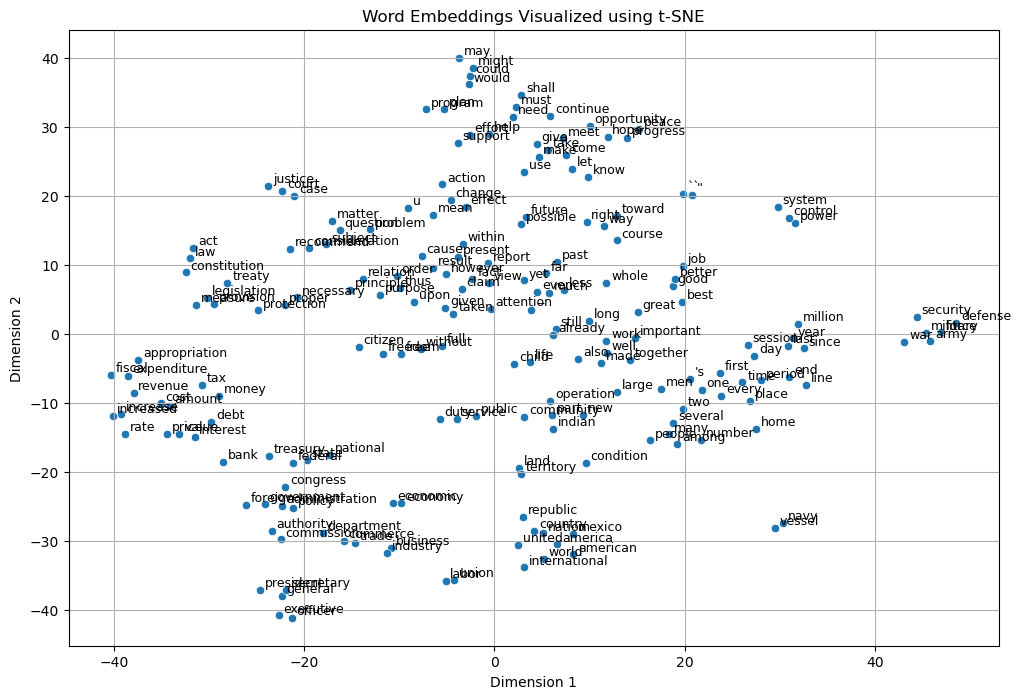

In [27]:
# Plotting the t-SNE-Reduced Vectors

# Create a DataFrame for plotting
df_tsne = pd.DataFrame({
    'word': words,
    'x': word_vectors_tsne[:, 0],
    'y': word_vectors_tsne[:, 1]
})

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_tsne, x='x', y='y')

# Annotate the points with words
for i in range(len(df_tsne)):
    plt.text(df_tsne['x'][i]+0.5, df_tsne['y'][i]+0.5, df_tsne['word'][i], fontsize=9)

plt.title('Word Embeddings Visualized using t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


### Part 4: Analyzing Changes in Word Meanings Over Time in Presidential Speeches

In this part, you'll investigate how the meanings of words have changed over time in presidential speeches. Building on the techniques learned in previous sections, you will focus on identifying and understanding shifts in language. No example code is provided for this section, so you are encouraged to approach the analysis either with your own code or in a more theoretical manner.

If you choose not to use code, describe in detail how you would theoretically conduct this analysis and interpret the findings. Also, point to potential difficulties or limitations you might encounter in such an analysis.

You can approach the below tasks with some freedom and for this exercise not all subtasks need to be completed or discussed in the final report. The goal is to think critically about how word embeddings can be used to analyze semantic change over time. Importantly, you should address the following questions in the final report:

As an advisor to a presidential campaign, how might you use your findings to inform your candidate’s language strategy?


#### I. Analyzing Change in Word Meanings Over Time:
1. **Comparing Word Meanings in Different Time Periods**  
   - Analyze how specific words may have changed in meaning between two distinct time periods (e.g., 1800 -- 1900 and 1900 -- 2000).
   - **Possible sub-tasks**:
     - Select a set of words that appear in both time periods. Think about words that may have shifted in relevance or context over time.
     - If using code, you could calculate word embeddings for each period and compare them to see how the “position” or “meaning” of the words has shifted. If not using code, explain how you might conceptually track these shifts, perhaps by examining the contexts in which these words appear.

2. **Measuring Semantic Change**  
   - Quantify or describe shifts in word meanings over time.
   - **Possible sub-tasks**:
     - If using code, you might measure semantic change by calculating the cosine similarity between word vectors for the same word across different periods. 
     - If you’re approaching this without coding, describe how you would interpret semantic shifts by comparing word associations, synonyms, or themes in each period.

### J. Visualizing Semantic Change  
- Illustrate the changes in word meanings across time.
  - **Possible sub-tasks**:
    - For those using code, you might create a plot of word vectors to show shifts in meaning visually. Consider how you might represent a word’s change in “position” on a timeline.
    - Without code, think about alternative ways to visualize this change. How would you present or describe a word’s evolving associations across different historical periods?

### K. Interpreting Semantic Shifts in Historical Context 
- Reflect on the broader implications of your findings.
  - **Possible sub-tasks**:
    - Can you find any words that have undergone significant shifts in meaning, potentially due to societal changes or historical events. Explain why these shifts are significant and how they reflect broader trends.
    - If you don’t have results, consider what types of shifts you would expect to find and what historical events or cultural changes might explain these.